<a href="https://colab.research.google.com/github/pjmartel/teaching/blob/master/enzymology/Enzyme_kinetics_data_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
# @title


### Estimation of enzyme kinetic parameters

In [49]:
#@title
import numpy as np
import pandas as pd
import numpy.random as rnd
from scipy.stats import linregress
import matplotlib.pyplot as plt
from matplotlib import style,rcParams
from seaborn import regplot
from scipy.stats import linregress
style.use('default')
rcParams.update({'axes.grid': True})
rcParams.update({'errorbar.capsize': 2})
pd.options.display.float_format = '{:,.3f}'.format
#style.use('dark_background')
#style.use('default')

In [50]:
#@title Imput Parameters
#variables
#Km = 12.3
#Vmax = 86.1
Km = 1 #@param
Vmax = 2 #@param
smin = 1 #@param
smax = 60 #@param
step = 5 #@param
repl = 3 #@param
npoints = 10 #@param
std_dev = 0.1 #@param
err_type = "relative" #@param ['absolut', 'relative']
outl_prob = 0.0 #@param



In [76]:
#@title
# Michaelis-Menten equation
def MM(K,V,s):
  return V*s/(K+s)

In [77]:
#@title
#generate the data
s = np.linspace(0.2*Km,3.0*Km,npoints)
v = np.zeros((len(s),repl))
for i in range(repl):
  v[:,i] = MM(Km,Vmax,s)
err = rnd.normal(0,std_dev,v.shape)
if err_type == "absolut":
  v = v + err
else:
  v = v * err
from sys import stdout
#np.savetxt(stdout, np.hstack([s.reshape(-1,1),v]),fmt=" %5.2f ")

In [78]:
#@title
# create a pandas data frame with the data
# also works:
# enz_data.iloc[:,1:4].mean(axis=1)
# enz_data.iloc[:,1:4].std(axis=1)
#
columns = ['[A]']
columns = columns + ['v'+str(i+1) for i in range(repl)]
enz_data = pd.DataFrame(np.hstack([s.reshape(-1,1),v]),columns=columns)
enz_data['Mean v']=enz_data[columns[1:]].mean(axis=1)
enz_data['Std v']=enz_data[columns[1:]].std(axis=1)
enz_data['fit_error']=enz_data['Mean v']-MM(Km,Vmax,enz_data['[A]'])
enz_data

,[A],v1,v2,v3,Mean v,Std v,fit_error
0,0.200,0.322,0.481,0.525,0.443,0.107,0.109
1,0.511,0.620,0.702,0.612,0.644,0.050,-0.032
2,0.822,0.870,0.868,0.994,0.911,0.072,0.008
3,1.133,1.035,1.148,1.272,1.151,0.119,0.089
4,1.444,1.288,1.096,1.155,1.180,0.098,-0.002
5,1.756,1.241,1.449,1.408,1.366,0.111,0.092
6,2.067,1.471,1.349,1.286,1.369,0.094,0.021
7,2.378,1.467,1.404,1.587,1.486,0.093,0.078
8,2.689,1.441,1.485,1.473,1.466,0.023,0.009
9,3.000,1.565,1.328,1.457,1.450,0.119,-0.050


In [79]:
#@title
# Create a pandas dataframa for storing the various estimates
df_estimates = pd.DataFrame(np.zeros((2,4)),index = ['Km','Vmax'],columns=['True','L-B','H-W','E-CB'])
df_estimates['True'] = Km,Vmax
df_estimates

,True,L-B,H-W,E-CB
Km,1,0.000,0.000,0.000
Vmax,2,0.000,0.000,0.000


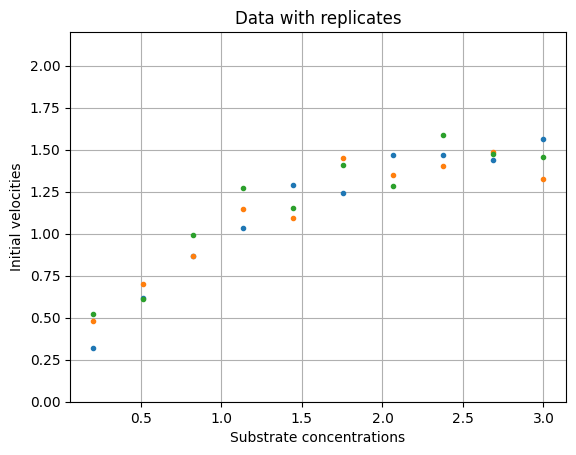

In [80]:
#@title


plt.title("Data with replicates")
plt.xlabel("Substrate concentrations")
plt.ylabel("Initial velocities")
plt.ylim(0,1.1*Vmax)
plt.plot(s,v,'.');

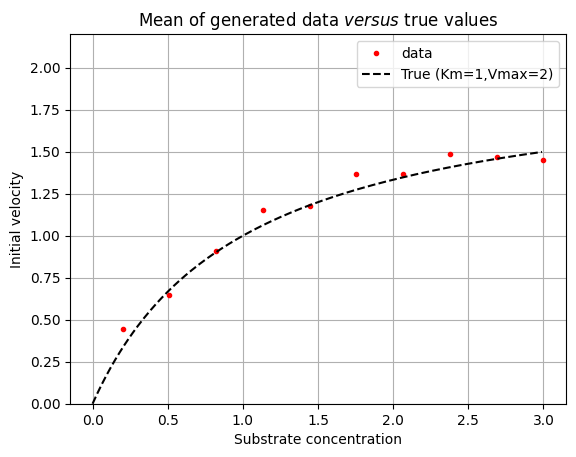

In [81]:
#@title
plt.plot('[A]','Mean v','r.',data=enz_data,label="data")
sz = np.arange(0,s.max(),0.01)
plt.plot(sz,MM(Km,Vmax,sz),'k--',label="True (Km={},Vmax={})".format(Km,Vmax))
plt.title("Mean of generated data $\mathit{versus}$ true values")
plt.xlabel("Substrate concentration")
plt.ylim(0,1.1*Vmax)
plt.ylabel("Initial velocity")
_ = plt.legend()
#plt.plot(s,v,'k.')

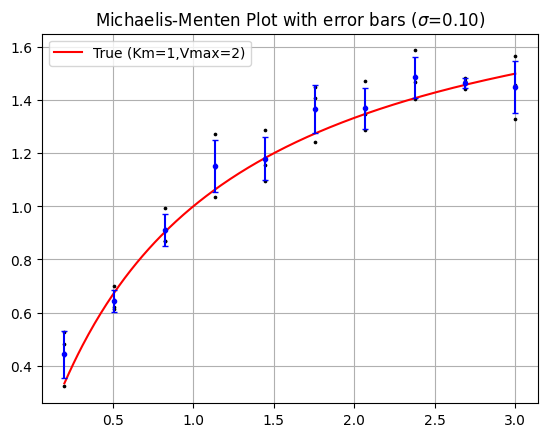

In [82]:
#@title
# Smooth interpolation
from scipy.interpolate import make_interp_spline, BSpline
for i in range(repl):
  plt.plot(s,v[:,i],'k.', ms=3.3)
tmp = MM(Km,Vmax,s)
snew = np.linspace(s.min(),s.max(),300)
spl = make_interp_spline(s,tmp,k=9)
#plt.plot(s,MM(Km,Vmax,s),'g-')
plt.plot(snew,spl(snew),'r-',label="True (Km={},Vmax={})".format(Km,Vmax))
#plt.plot(snew,MM(Km,Vmax,snew),'g-')
#plt.errorbar(s,MM(Km,Vmax,s),fmt='g.',xerr=0.0,yerr=v.std(axis=1),capsize=2)
plt.legend()
plt.errorbar(s,v.mean(axis=1),fmt='b.',xerr=0.0,yerr=v.std(axis=1),capsize=2)
_ = plt.title("Michaelis-Menten Plot with error bars ($\sigma$={:4.2f})".format(std_dev))

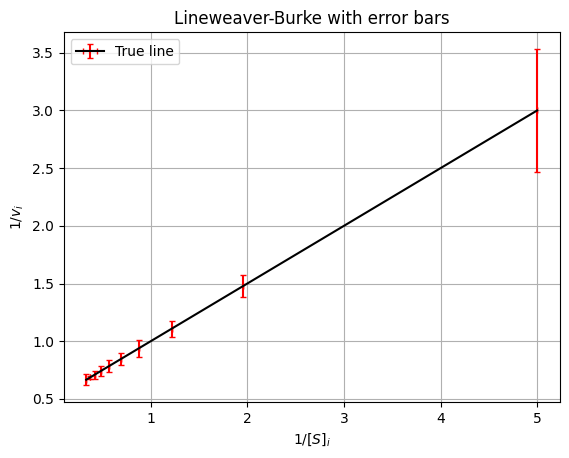

In [83]:
#@title
sinv = 1 /s
vinv = 1 /v
vminv = 1 /v.mean(axis=1)
plt.errorbar(sinv,sinv*Km/Vmax+1/Vmax,fmt="k-",ecolor='r',xerr=0,
             yerr=vinv.std(axis=1),capsize=2,label="True line")
#plt.errorbar(sinv,vminv,fmt="k-",ecolor='r',xerr=0,
#             yerr=vinv.std(axis=1),capsize=2,label="True line")
#plt.plot(sinv,vinv,"k.")
#plt.hlines(0.5,0,0.5,linestyle="dashed")
#plt.vlines(0.5,0,0.5,linestyle="dashed")
plt.ylabel("$1/v_i$")
plt.xlabel("$1/[S]_i$")
plt.title("Lineweaver-Burke with error bars")
plt.legend()
plt.show()

In [84]:
#@title
#plt.plot(vinv.std(axis=1))

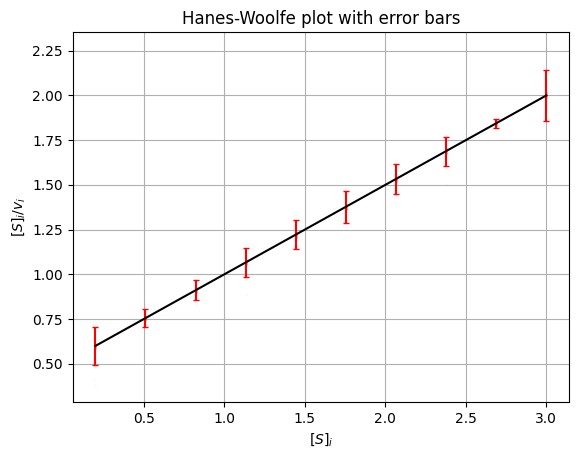

In [85]:
#@title
# Hanes-Woolfe with error bars
#shw = np.repeat(s.reshape(-1,1),v.shape[1],axis=1)
shw = np.vstack(v.shape[1]*[s]).T
vhw = shw / v
plt.errorbar(s,Km/Vmax+s/Vmax,fmt="k-",ecolor='r',xerr=0,
             yerr=vhw.std(axis=1),capsize=2)
plt.plot(s,vhw,"g.",ms=0.05)
#plt.hlines(0.5,0,0.5,linestyle="dashed")
#plt.vlines(0.5,0,0.5,linestyle="dashed")
plt.ylabel("$[S]_i/v_i$")
plt.xlabel("$[S]_i$")
plt.title("Hanes-Woolfe plot with error bars")
plt.show()

In [86]:
#@title
from seaborn import regplot,residplot

Km = 0.597, Vmax= 1.690, R = 0.9787



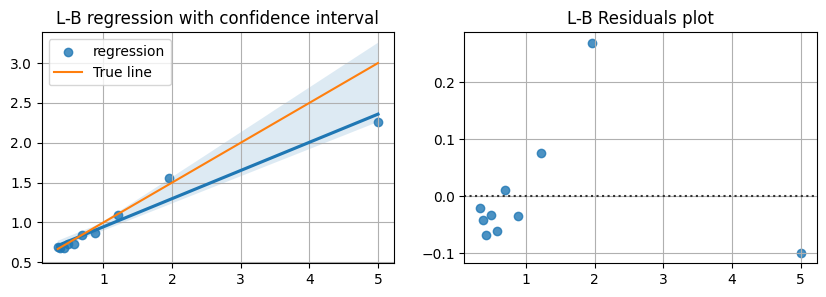

In [87]:
#@title
vlb = v[:,0]
vlb = v.mean(axis=1)
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
regplot(x=1/s,y=1/vlb,label="regression")
m, b,r,_,_ = linregress(1/s,1/vlb)
_ = plt.plot(sinv,sinv*Km/Vmax+1/Vmax,label="True line")
_ = plt.title("L-B regression with confidence interval")
plt.legend()
plt.subplot(1,2,2)
plt.title("L-B Residuals plot")
residplot(x=1/s,y=1/vlb,label='residuals')
#print(m,b,r)
print("Km = {:5.3f}, Vmax= {:5.3f}, R = {:.4f}".format(m/b,1/b,r))
print()
df_estimates['L-B'] = m/b,1/b

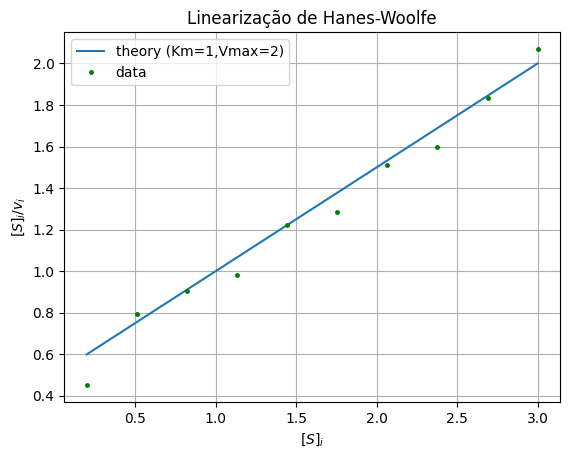

In [88]:
#@title
# Hanes-Woolfe mean of replicates with linear regression
#shw = np.repeat(s.reshape(-1,1),v.shape[1],axis=1)
shw = s
vhw = v.mean(axis=1)
#vhw = v[:,0]
vhw = s / vhw
#plt.errorbar(s,Km/Vmax+s/Vmax,fmt="k-",ecolor='r',xerr=0,
#             yerr=vhw.std(axis=1),capsize=2)
plt.plot(s,Km/Vmax+s/Vmax,label="theory (Km={},Vmax={})".format(Km,Vmax))
plt.plot(s,vhw,"g.",ms=5,label="data")
#plt.hlines(0.5,0,0.5,linestyle="dashed")
#plt.vlines(0.5,0,0.5,linestyle="dashed")
plt.legend()
plt.ylabel("$[S]_i/v_i$")
plt.xlabel("$[S]_i$")
plt.title("Linearização de Hanes-Woolfe")
plt.show()

Km = 0.810, Vmax= 1.904, R = 0.9921


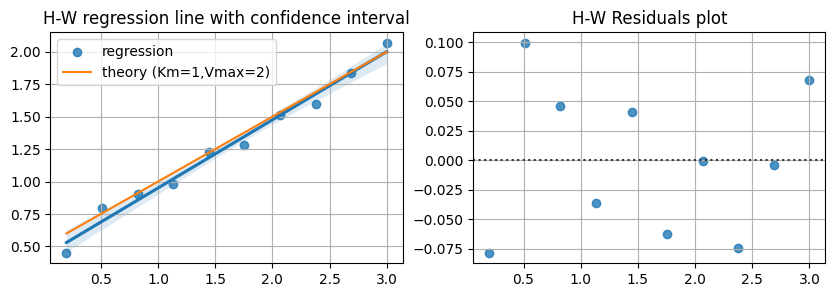

In [89]:
#@title
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
regplot(x=s,y=vhw,label="regression")
m, b,r,_,_ = linregress(s,vhw)
_ = plt.title("H-W regression line with confidence interval")
plt.plot(s,Km/Vmax+s/Vmax,label="theory (Km={},Vmax={})".format(Km,Vmax))
plt.legend()
plt.subplot(1,2,2)
plt.title("H-W Residuals plot")
residplot(x=s,y=vhw)
#print(m,b,r)
#print(1/m,b/m)
print("Km = {:5.3f}, Vmax= {:5.3f}, R = {:.4f}".format(b/m,1/m,r))
df_estimates['H-W'] = b/m, 1/m

#### Direct Linear Plot

Computing 45 intersections
Km = 0.835, Vmax= 1.922


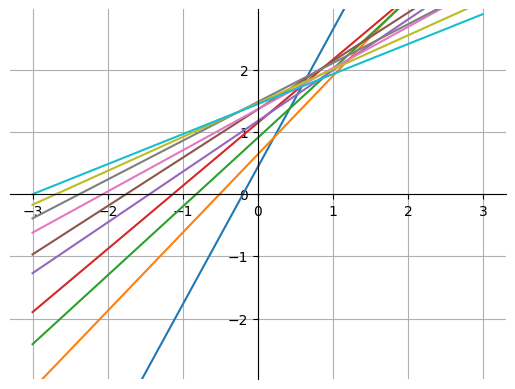

In [90]:
#@title
import matplotlib.pyplot as plt
vm = v.mean(axis=1)
x = np.arange(-s.max(),s.max(),0.01)
median_Vmax = []
median_Km = []
mmlines = np.vstack((vm/s,vm)).T
n_int = len(s)*(len(s)-1)//2
Km_int = np.zeros(n_int)
Vmax_int = np.zeros(n_int)

for m, b in mmlines:
  plt.plot(x,m*x+b)

print("Computing {:d} intersections".format(n_int))
for i in range(mmlines.shape[0]):
  for j in range(i):
    m1, b1 = mmlines[i]
    m2, b2 = mmlines[j]
    x = (b2-b1)/(m1-m2)
    y = (b2*m1-b1*m2)/(m1-m2)
    median_Km.append(x)
    median_Vmax.append(y)
    #print(x,y)
    #pass
    #print(i,j,mmlines[i],mmlines[j])rray python

ax = plt.gca()
ax.axis([-1.1*s.max(),1.1*s.max(),-2*vm.max(),2*vm.max()])
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
#ax.set_xlabel("Km")
#ax.set_ylabel("Vmax")

#ax.set_ylabel?

print("Km = {:5.3f}, Vmax= {:5.3f}".format(np.median(median_Km), np.median(median_Vmax)))
df_estimates['E-CB'] = np.median(median_Km), np.median(median_Vmax)

In [91]:
#@title
df_estimates

,True,L-B,H-W,E-CB
Km,1,0.597,0.810,0.835
Vmax,2,1.690,1.904,1.922


In [92]:
#@title
vm

array([0.44252375, 0.64428678, 0.9107117 , 1.15149642, 1.17962993,
       1.36605853, 1.36872213, 1.48606129, 1.46638357, 1.45005969])

In [93]:
#@title
s

array([0.2       , 0.51111111, 0.82222222, 1.13333333, 1.44444444,
       1.75555556, 2.06666667, 2.37777778, 2.68888889, 3.        ])

#### Non-linear least square fitting (constant relative error)

Km = 0.708, Vmax= 1.828


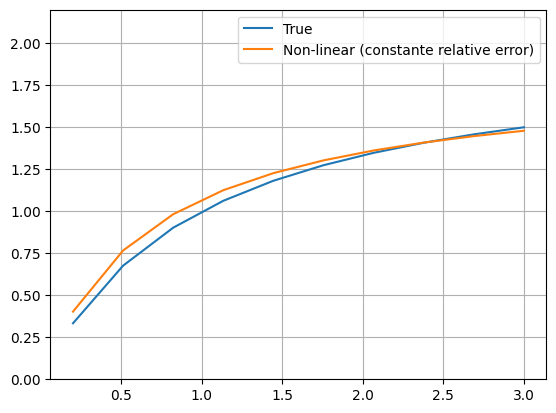

In [94]:
#@title
# Non-linear least square fitting (constant relative error)
# Johansen and Lumry
D = (vm*vm / s / s).sum()*vm.sum()-(vm*vm/s).sum()*(vm/s).sum()
NL_Vmax = ((vm*vm / s / s).sum()*(vm*vm).sum()-((vm*vm/s).sum())**2) / D
NL_Km = ((vm*vm).sum()*(vm/s).sum()-(vm*vm/s).sum()*vm.sum()) / D
plt.plot(s,MM(Km,Vmax,s),label="True")
plt.plot(s,MM(NL_Km,NL_Vmax,s),label = "Non-linear (constante relative error)")
plt.legend()
plt.ylim(0,1.1*Vmax)
print("Km = {:5.3f}, Vmax= {:5.3f}".format(NL_Km, NL_Vmax))

The error in the estimates is computed using the experimental variance:

$$ \sigma_{exp}^2 = \frac{\widehat{SS}}{(n-2)}$$

where $\widehat{SS}$ is the weighted sum of squares:

$$ \widehat{SS} = \sum w (1/v-1/\hat v)^2  $$

for constant relative error the weights are $w_i = v_i^2$, and for constant error they are $ w_i = \hat v^3v$ .

In [70]:
#@title
# Compute the experimental variance
v_hat = MM(NL_Km, NL_Vmax,s)
exp_var = (vm*vm*(1/vm - 1/v_hat)**2).sum() / (npoints-2)
Vmax_var = (NL_Vmax)**4 * exp_var**2 * (vm*vm / s / s).sum()
Vmax_var = Vmax_var / ((vm*vm / s / s).sum() * (vm*vm).sum() - ((vm*vm/s).sum())**2)
Vmax_var,exp_var

(3.0191049604822548e-05, 0.004323775150698557)

In [71]:
#@title
D = (vm*vm / s / s).sum()*vm.sum()-(vm*vm/s).sum()*(vm/s).sum()

In [72]:
#@title
B = (vm*vm).sum()*(vm/s).sum()-(vm*vm/s).sum()*vm.sum()

In [73]:
#@title
D, B

(33.87999480026811, 25.59613147878362)

In [74]:
#@title
#A/D,B/D

In [75]:
#@title
